<a href="https://colab.research.google.com/github/andersjes/Deep-Learning/blob/main/Lab5_Initialization_BatchNorm_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 5: Training neural networks (part 1/2)
**Like always, remember to set Runtime environment to GPU**

In this lab we will explore different tools that will help you train your own neural networks.

Today we will be using fully connected networks. Next time, in part 2, we will be using ConvNets.

**Prerequisites:** You will most likely find it easier to solve this lab if you have already completed the [PyTorch tutorial](https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2024/blob/main/Lab5_PyTorch_Tutorial.ipynb) and read the slides for Lecture 5.

##1. Download the CIFAR 10 dataset
We will be using the CIFAR 10 dataset.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

# Batch size
bs = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 40046090.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Display some stats

Batch size 256
Image size torch.Size([3, 32, 32])
Range of pixel intensities tensor(0.) tensor(1.)
num_train 50176
num_test 10240
images.shape torch.Size([256, 3, 32, 32])
images.min() tensor(0.)
images.max() tensor(1.)


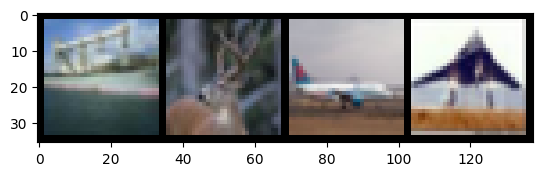

 ship  deer plane plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print batch size
print('Batch size',bs)

#print size of image
print('Image size',trainset[0][0].shape)

#range of pixcel intensity
print('Range of pixel intensities',trainset[0][0].min(),trainset[0][0].max())

# Number of samples
num_train = bs * len(trainloader)
num_test = bs * len(testloader)
print('num_train',num_train)
print('num_test',num_test)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('images.shape',images.shape)
print('images.min()',images.min())
print('images.max()',images.max())

# show 4 images
imshow(torchvision.utils.make_grid(images[0:4]))

# print 4 labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

###Questions
1. What is the batch size?
2. What is the size of the images?
3. What is the range of the pixel intensities?

##2. Task 0: Preprocessing
Recall that we always prefer to have our data zero-centered. For this purpose, we can extend the transform function used above:

```
transform = transforms.Compose([transforms.ToTensor()])
```

This transformer converts a loaded image to a PyTorch tensor, as required by PyTorch models. As demonstrated in the [PyTorch Transfer Learning tutorial](https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2024/blob/main/Lab5_PyTorch_TransferLearning.ipynb) you can chain together multiple transforms to perform a sequence of operations for data augmentation and/or preprocessing(see complete list [here](https://pytorch.org/vision/0.15/transforms.html)).

Your task is to add a second transformation that normalizes the pixel intensities to range -1 to 1. Use [`transforms.Normalize()`](https://pytorch.org/vision/0.15/generated/torchvision.transforms.Normalize.html) with suitable input parameters. The normalization is based on the equation

```
y = (x - mean) / std
```

where mean and std are user-defined.

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Your code goes here

# Re-initialize trainloader and testloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)

# Verify that intensities are in range -1 to 1
dataiter = iter(trainloader)
images, labels = next(dataiter)
print('images.min()',images.min())
print('images.max()',images.max())

Files already downloaded and verified
Files already downloaded and verified
images.min() tensor(-1.)
images.max() tensor(1.)


###Questions
Below you are going to initialize and normalize the network weights. To prepare for this task, answer the following questions using appropriate PyTorch functions (use Google to figure out which):
1. What is the mean and standard deviation (std) of tensor `x` below?
2. What is the mean and std `y`?
3. What is the mean and std `z`?

Bonus task: See of you can figure out a formula to calculate the mean and std of `x` and `y`, given the mean and std and `x`.

In [6]:
x = torch.randn(512, 512)
y = x * 10 + 2
z = (y-2) / 10

#mean and std
print(torch.mean(x),torch.std(x))
print(torch.mean(y),torch.std(y))
print(torch.mean(z),torch.std(z))

tensor(0.0020) tensor(0.9988)
tensor(2.0202) tensor(9.9876)
tensor(0.0020) tensor(0.9988)


##3. Base model
We'll first create a base model that we can use for our initial experiments. The base model is a fully connected neural network. By default it has

- `L = 10` layers
- `N = 16` units in each hidden layer.

When initializing the model you can specify

- a `normalizer` function, which is applied when initializing the weight matrix `W` of each layer. The input to the normalizer functions is `W` and the output is some normalized version of `W`, like Xavier or Kaiming.

- an `activation_function` which could be sigmoid, tanh, ReLu, etc.

- a `preprocess_function` which is applied in each layer after calculating `Wx+b` but before applying the activation function. It can be used to implement batch normalization.

Initially we set all these functions to the identity function. In other words, the base model is a purely linear model without any activation functions, normalization or anything like that.

In [1]:
from torch import nn

def base_normalizer(x): return x
def base_activation(x): return x
def base_preprocess(x): return x

class BaseModel(nn.Module):
    def __init__(self,
                 normalizer = base_normalizer,
                 activation_function = base_activation,
                 preprocess_function = base_preprocess,
                 L = 10,
                 N = 16):

        super().__init__()

        self.W = nn.ParameterList() # List of weights
        self.b = nn.ParameterList() # List of biases
        self.L = L # Number of layers
        self.N = N # Number of units in each hidden layer
        self.activation_function = activation_function
        self.preprocess_function = preprocess_function
        self.layer_activations = [] # Store layer activations here

        # Initialize weights and biases
        for layer in range(L):
          dims = [self.N, self.N] # Size of hidden layer
          if layer == 0: dims = [32*32*3,N] # Size of first layer
          if layer == L-1: dims = [N,10] # Size of last layer
          W = nn.Parameter(normalizer(torch.randn(dims[0], dims[1]))) # Call normalizer here
          b = nn.Parameter(torch.zeros(dims[1]))
          self.W.append(W)
          self.b.append(b)

    # Forward propagation
    def forward(self, x):
        self.layer_activations = []
        x = x.view(-1, 32*32*3) # Vectorize image to a 32*32*3 dimensional vector
        for layer in range(self.L):
          x = x @ self.W[layer] + self.b[layer]
          x = self.preprocess_function(x) # Call preprocess function before activation
          x = self.activation_function(x)
          self.layer_activations.append(x) # Store activations
        return x

    # Return stored layer activations
    def activations(self):
        return self.layer_activations

###3.1 Test the model
Let's test the model:

In [7]:
# Move data to GPU
images = images.cuda()
labels = labels.cuda()

# Calculate scores
model = BaseModel().cuda()
scores = model(images)  # predictions

print(scores.shape)

torch.Size([256, 10])


###3.2 Calculating the accuracy
These numbers are scores (logits), which don't have any meaningful interpretation. We can convert them into class probabilities using softmax. Since we are only going to be interested in the model's accuracy, we will wrap the softmax inside the function `accuracy` that calculates the accuracy on a batch:

In [8]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1) #instead of returning the maximum value itself, torch.argmax() returns the index (position) where that maximum value occurs.
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

print('Accuracy', accuracy(scores,labels))

Accuracy tensor(0.1055, device='cuda:0')


### Question
1. What does `torch.argmax` do?

###3.3 Calculating the loss
I order to train your model, we also need a loss function. We will use the cross entropy loss [already provided in PyTorch](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy). Note that `cross_entropy` does the softmax for you, so the input is just the scores.

In [9]:
import torch.nn.functional as F
loss_func = F.cross_entropy
loss = loss_func(scores, labels)
print('Loss', loss)

Loss tensor(15730728., device='cuda:0', grad_fn=<NllLossBackward0>)


###3.4 Getting layer activations and gradients
One special propoerty of our model is that it stores the activations after each layer (in variable `self.layer_activations`).

Our goal is develop tools that we can use to inspect our model both before and during training. For this purpose it will be useful to be able to grab the layer activations as well as the gradients at each layer. The activations have alreay been stored during our forward propagation and can be extracted as follows:

In [10]:
activations = model.activations()
print('Activation list length:',len(activations))
print('Activations shape layer 1:',activations[0].shape)

Activation list length: 10
Activations shape layer 1: torch.Size([256, 16])


To get the gradients w.r.t. the loss, first call `loss.backward()` and then access the `grad` property of the relevant model parameters.

In [11]:
# Calculate gradients
loss.backward()

*Side-note:* If you are interested in understanding in detail how `backward()` works, I recommend [this blog post](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95).

Since we are going to need both the layer activations and layer-wise gradients, lets wrap that up in a single function:

In [12]:
def get_layer_data(model):
  gradients = []
  layer_names = []

  with torch.no_grad():
    for name, param in model.named_parameters():
      if param.requires_grad and name.startswith('W'):
          layer_names.append(name)
          gradients.append(param.grad)

  activations = model.activations()

  return layer_names, activations, gradients

layer_names, activations, gradients = get_layer_data(model)
print('layer_names',layer_names)
print('Activation list length:',len(activations))
print('Activations shape layer 1:',activations[0].shape)
print('Gradient list length:',len(gradients))
print('Gradient shape layer 1:',gradients[0].shape)

layer_names ['W.0', 'W.1', 'W.2', 'W.3', 'W.4', 'W.5', 'W.6', 'W.7', 'W.8', 'W.9']
Activation list length: 10
Activations shape layer 1: torch.Size([256, 16])
Gradient list length: 10
Gradient shape layer 1: torch.Size([3072, 16])


Note that we are not considering the biases in this Lab.

###Questions
1. Why is the shape of the activations of the first layer [256,16]?

256 is the batch size and 16 is number of neurons.
2. Why is the shape of the gradients of the first layer [3072,16]?

3072 is the number of input features. ex. 32*32*3=3072


###3.5 Getting layer stats
We can create a simple function that calculates the mean and the variance of the layer activations and gradients. For the gradients, we are interested in the *gradient flow*, so we will take the mean of the *absolute* gradient values.

In [13]:
def get_layer_stats(x,absolute=False):
  avg = []
  std = []
  for layer in range(len(x)):
    if absolute:
      avg.append(x[layer].abs().mean().detach().cpu().numpy())
    else:
      avg.append(x[layer].mean().detach().cpu().numpy())

    std.append(x[layer].std().detach().cpu().numpy())

  return avg, std

activation_mean, activation_std = get_layer_stats(activations)
gradient_mean, gradient_std = get_layer_stats(gradients,absolute=True)

print('activation_mean',activation_mean)
print('activation_std',activation_std)
print('gradient_mean',gradient_mean)
print('gradient_std',gradient_std)

activation_mean [array(-0.9584068, dtype=float32), array(10.515477, dtype=float32), array(21.520798, dtype=float32), array(46.34395, dtype=float32), array(57.98977, dtype=float32), array(78.12552, dtype=float32), array(-7123.1113, dtype=float32), array(-25165.777, dtype=float32), array(-81880.35, dtype=float32), array(101817.234, dtype=float32)]
activation_std [array(30.151188, dtype=float32), array(116.10885, dtype=float32), array(429.67294, dtype=float32), array(1491.0935, dtype=float32), array(5707.321, dtype=float32), array(27374.18, dtype=float32), array(110922.77, dtype=float32), array(585202.25, dtype=float32), array(2780634.5, dtype=float32), array(10803245., dtype=float32)]
gradient_mean [array(12362.347, dtype=float32), array(203598.75, dtype=float32), array(209265.61, dtype=float32), array(213732.06, dtype=float32), array(156809.77, dtype=float32), array(142689., dtype=float32), array(189967.88, dtype=float32), array(152096.1, dtype=float32), array(207599.9, dtype=float32), 

###3.6 Visualizing layer stats
These numbers are perhaps not very easy to interpret, so lets make a function that allows to plot histograms (and display mean and standard deviation at the same time).

Note that you can specifiy a fixed range of x values (like -1 to 1). If set to `None` the x range is adapted to each individual plot. So notice the values on the x-axis.

Gradients:



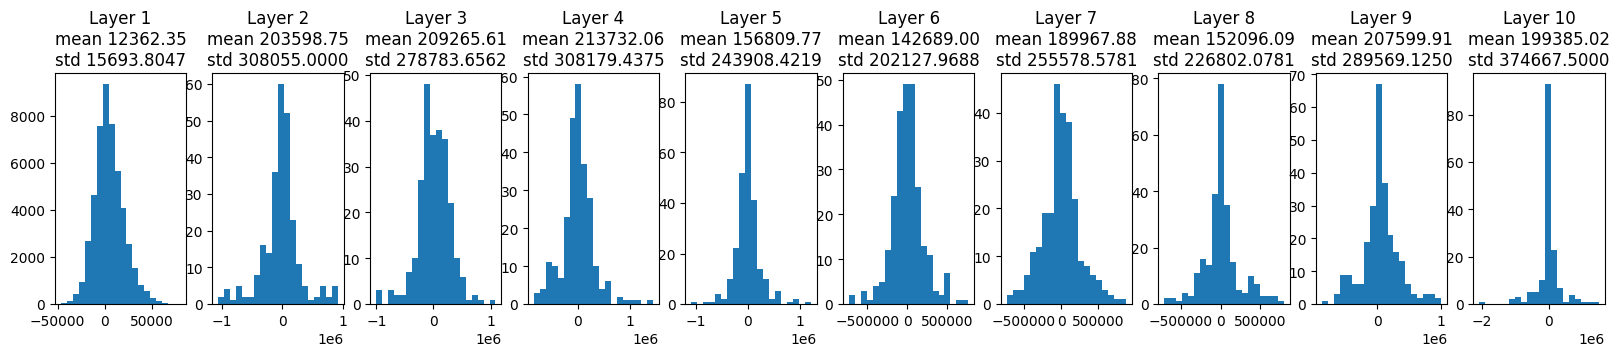

Activations:



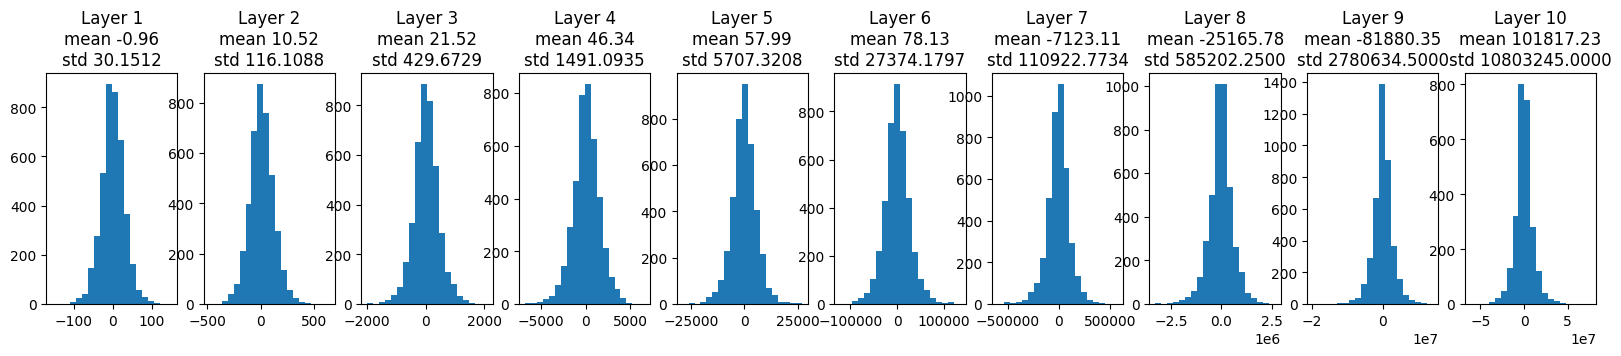

In [14]:
def plot_hist(hs,xrange=(-1,1),avg=None,sd=None):
  plt.figure(figsize=(20,3))
  for layer in range(len(hs)):
    plt.subplot(1,len(hs),layer+1)
    activations = hs[layer].detach().cpu().numpy().flatten()
    plt.hist(activations, bins=20, range=xrange)

    title = 'Layer ' + str(layer+1)
    if avg:
      title += '\n' + "mean {0:.2f}".format(avg[layer])
    if sd:
      title += '\n' + "std {0:.4f}".format(sd[layer])

    plt.title(title)

print('Gradients:\n')
plot_hist(gradients,xrange=None,avg=gradient_mean,sd=gradient_std)
plt.show()

print('Activations:\n')
plot_hist(activations,xrange=None,avg=activation_mean,sd=activation_std)
plt.show()


### Questions
Carefully inspect the histograms above, and remember that the x-axes can be scaled differently.
1. What happens to the gradients across layers? How are they distributed? Do they get smaller or larger towards the end of the network?

the gradiants gets closer to zero for each layer. This is known as the vanishing gradiant problem. When gradiants below 1 is multiplied together for each layer during backpropagation, this becomes an issue.


2. What about the activations?

they are also getting close to zero for each layer. This is because of activation saturation. this happens if too many neurons die, and a linear model will be made.

###3.7 Wrapping up
Finally, let's combine all of the above into just one function that we can call. To do this we first define a helper function `get_stats` which takes a model as input, runs a batch trough the model, and calculates all the stats that we need.

In [15]:
def get_stats(model,dataloader=trainloader):

  dataiter = iter(dataloader)
  images, labels = next(dataiter)
  images = images.cuda()
  labels = labels.cuda()

  scores = model(images)  # predictions
  loss = loss_func(scores, labels)
  acc = accuracy(scores,labels)

  # Calculate gradients
  loss.backward()

  layer_names, activations, gradients = get_layer_data(model)

  activation_mean, activation_std = get_layer_stats(activations)
  gradient_mean, gradient_std = get_layer_stats(gradients,absolute=True)

  stats = {'loss': loss,
           'accuracy': acc,
           'names': layer_names,
           'grads': gradients,
           'activations': activations,
           'activation_mean': activation_mean,
           'activation_std': activation_std,
           'gradient_mean': gradient_mean,
           'gradient_std': gradient_std
           }

  return stats

Here is the function to display the stats:

In [16]:
def show_stats(stats):
  print('loss',stats['loss'].detach().cpu().numpy())
  print('accuracy',stats['accuracy'].detach().cpu().numpy(),'\n')

  print('Gradients:\n')
  print(' (note that we use the mean of the absolute gradient values to quantify gradient flow\n')
  #[print(name, avg, std) for name, avg, std in iter(zip(stats['names'],stats['gradient_mean'],stats['gradient_std']))]

  plot_hist(stats['grads'],xrange=None,avg=stats['gradient_mean'],sd=stats['gradient_std'])
  plt.show()

  print('Activations:\n')
  #[print(name, avg, std) for name, avg, std in iter(zip(stats['names'],stats['activation_mean'],stats['activation_std']))]

  plot_hist(stats['activations'],xrange=None,avg=stats['activation_mean'],sd=stats['activation_std'])
  plt.show()

So from now on we just make these two function calls:

loss 18114636.0
accuracy 0.0859375 

Gradients:

 (note that we use the mean of the absolute gradient values to quantify gradient flow



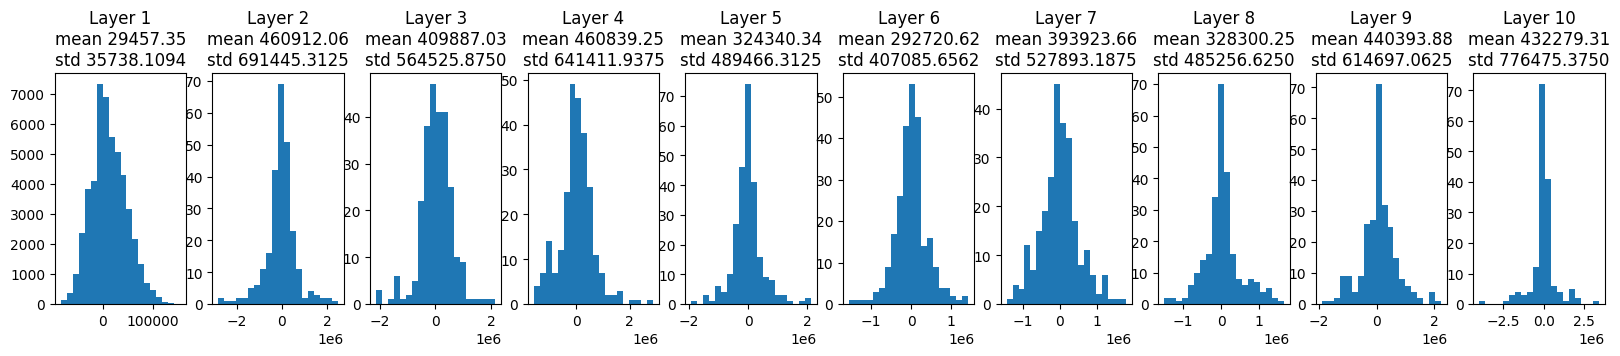

Activations:



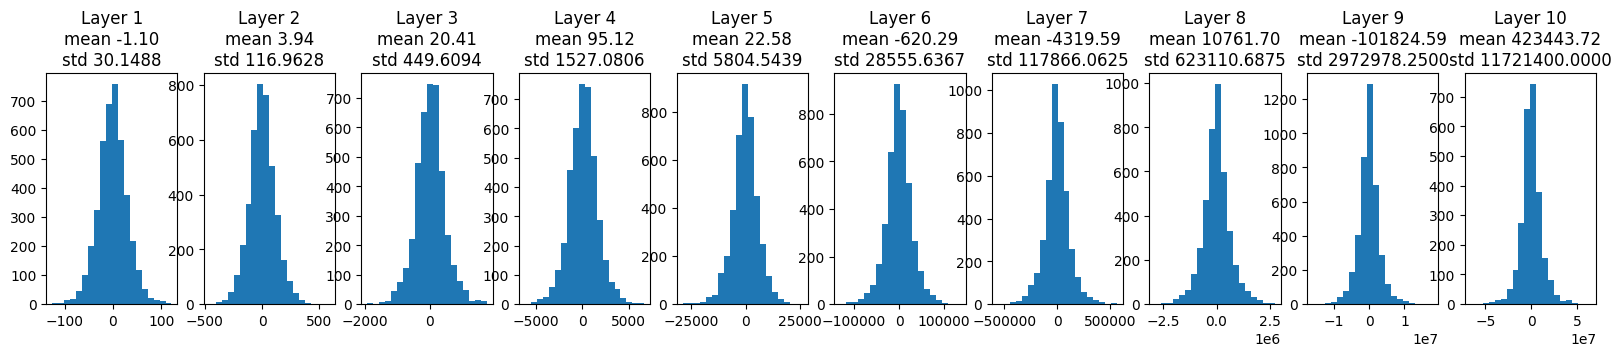

In [17]:
# Calculate stats
stats = get_stats(model)

# Show stats
show_stats(stats)

## 4. Task 1: tanh activation
Your task is very simple: Add tanh activation function to our base model and explain what you see.

loss 2.525615
accuracy 0.12890625 

Gradients:

 (note that we use the mean of the absolute gradient values to quantify gradient flow



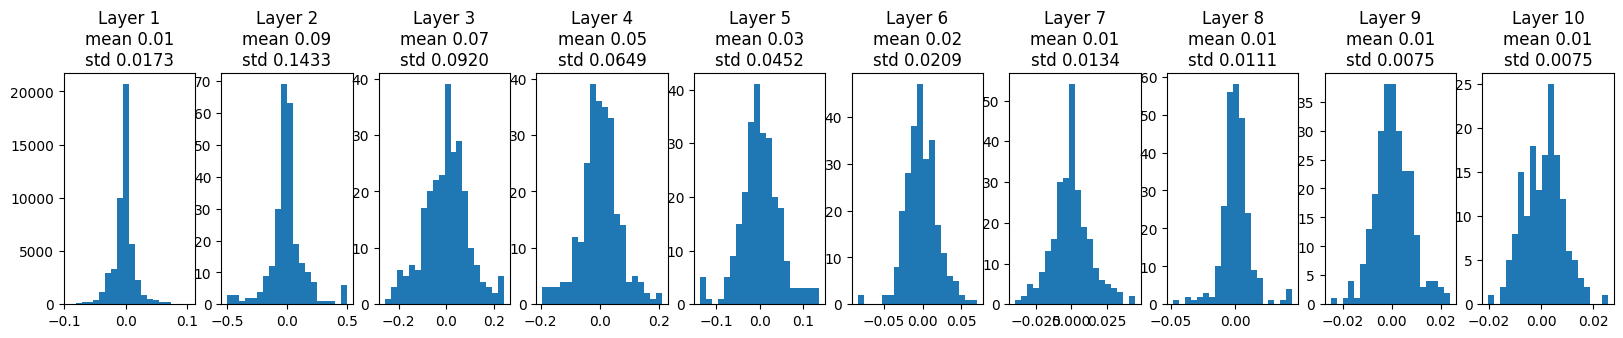

Activations:



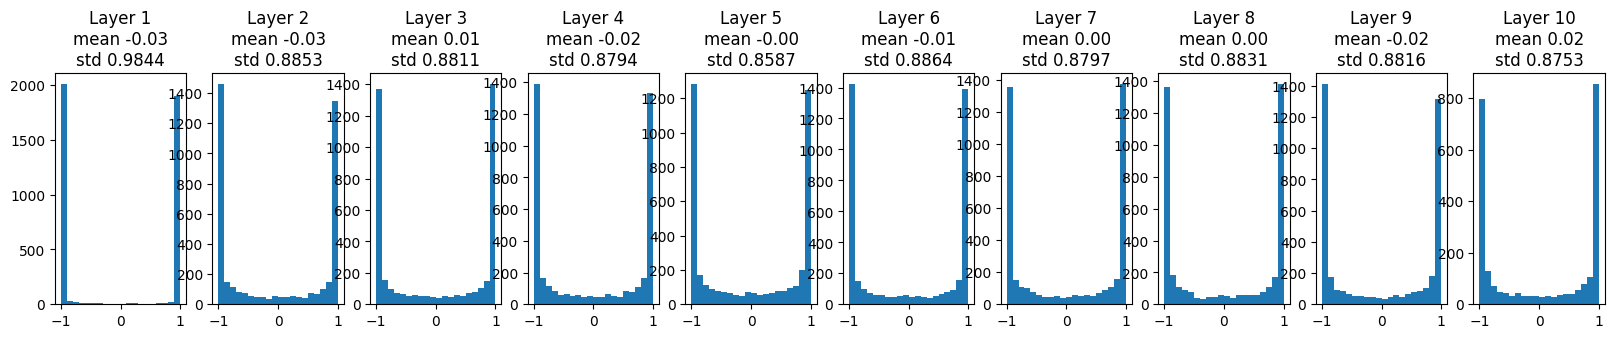

In [18]:
def tanh(x):
  return torch.tanh(x)

model_tanh = BaseModel(activation_function=tanh).cuda()
stats = get_stats(model_tanh)
show_stats(stats)

### Questions:
1. How are the gradients and activations distributed across layers?

gradiant is still close to 0. However, activation is either -1 or 1. This is also the result of saturation.
2. Is there gradient flow through the entire network?

if they are stable of each layer, there is great flow. in am not sure if the peak are narrow?
3. Do the activations have similar variance across layers?

yes.
4. Are we within the linear range of tanh, within the saturated range, or a little of both?

i think it is saturated. because of either -1 or 1.

##5. Task 2: Increase values of initial weights
In our base model the weights are initialized with random values from a standard normal disitrbution (mean 0 and standard deviation 1). Let's increase the std to 10 and see what happens. Note that we keep using tanh acivation.

loss 2.8453584
accuracy 0.0703125 

Gradients:

 (note that we use the mean of the absolute gradient values to quantify gradient flow



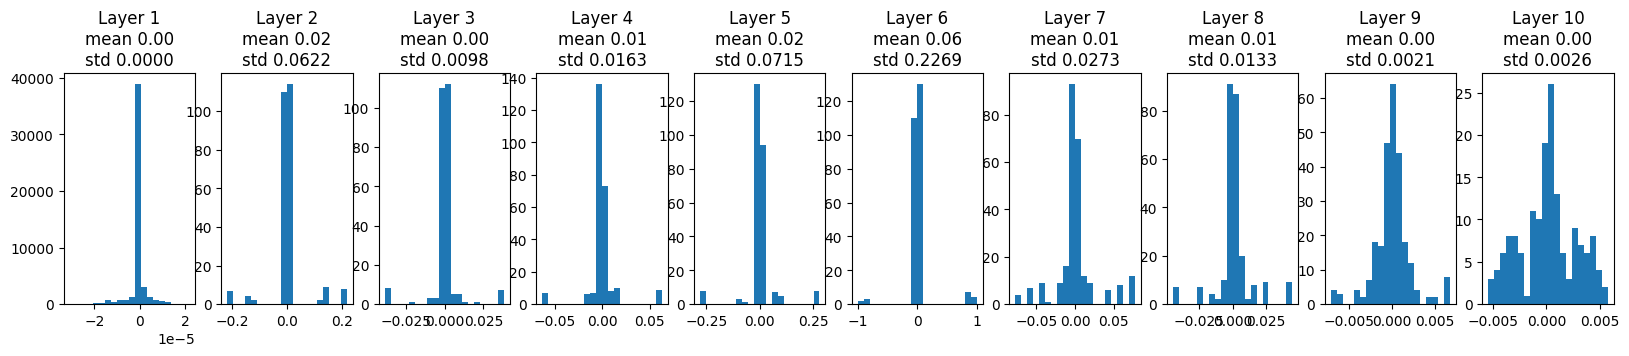

Activations:



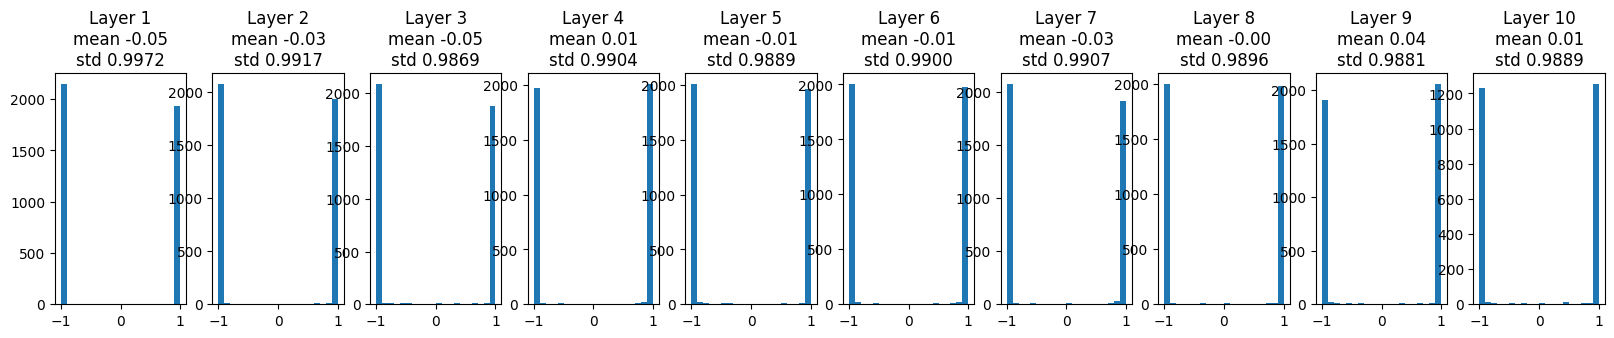

In [19]:
def upscale(x): return x * 10

model_saturated = BaseModel(normalizer=upscale, activation_function=tanh).cuda()
stats = get_stats(model_saturated)
show_stats(stats)

### Questions:
1. How are the gradients and activations distributed across layers?

the gradiant flow looks better. has same mean and same std. However, it is not as peaked.

Actiation. this is even more saturated.
2. Is there gradient flow through the entire network?
3. Do the activations have similar variance across layers?
4. Are we within the linear range of tanh, within the saturated range, or a little of both?

##6. Task 3: Implement Xavier initialization
Your task is to implement Xavier initialization by providing a new normalizer function. Remember that the normalizer takes a weight matrix (`x`) as input, which contains random values with zero mean and standard deviation 1. To change the standard deviation of `x` to some value `sd`, simply multiply `x` with `sd`.

Note that there are different ways to implement Xavier. In the lecture slides, we normalize based on the number of columns of the weight matrix (often referred to as the *fan-in*). Others normalize based on the number of rows (*fan-out*). Others again normalize based on the sum of the fan-in and fan-out. For instance, [this is how PyTorch does it](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_normal_).

**Do not use PyTorch's Xavier implementation - make your own :-)**

In [ ]:
def xavier(x):
  # Your code goes here

model_xavier = BaseModel(normalizer=xavier, activation_function=tanh).cuda()
stats = get_stats(model_xavier)
show_stats(stats)

### Questions:
1. How are the gradients and activations distributed across layers?
2. Is there gradient flow through the entire network?
3. Do the activations have similar variance across layers?
4. Are we within the linear range of tanh, within the saturated range, or a little of both?

##7. Task 4: ReLu and Kaiming initialization
Your task is to change the activation function to ReLU. In this case, we know that Xavier initialization will not work, so you also need to implement Kaiming initialization.

You can check PyTorch's Kaiming formula [here](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) (again, recall that fan-in is the number of columns of the weight matrix).

**Again, make our own implementation - do not PyTorch's**

**Hint:** For ReLU you could use PyTorch's [`clamp`](https://pytorch.org/docs/stable/generated/torch.clamp.html#torch.clamp) function.

In [ ]:
def relu(x):
  # Your code goes here

def kaiming(x):
  # Your code goes here

model_kaiming = BaseModel(normalizer=kaiming, activation_function=relu).cuda()
stats = get_stats(model_kaiming)
show_stats(stats)

### Questions:
1. How are the gradients and activations distributed across layers?
2. Is there gradient flow through the entire network?
3. Do the activations have similar variance across layers?
4. Do enough of the ReLUs get activated in all layers?

##8. Task 5: Batch normalization
Finally, see if you can implement simple batch normalization (without the learnable parameters) by passing on a preprocessing function to our model. The input to the preprocess function is the result of multiplying layer input `x` with weight matrix `W` and adding the biases: That is: `y = Wx+b`. The output should be `z = (y - mean(y)) / std(y)`.

Hint: You can call `.mean()` and `.std()` on a tensor to get the mean and standard deviation, respectively. Remember to specify the correct axis.


In [ ]:
def batch_norm(y):
  # Your code goes here

In [ ]:
# Check your results
y = torch.randn(512,512)*10 + 2
print('before', y.mean(),y.std())
z = batch_norm(y)
print('after', z.mean(),z.std())

If your implementation is correct, z should have mean 0 and standard deviation 1.

In [ ]:
model_batchnorm = BaseModel(normalizer=kaiming, activation_function=relu,preprocess_function=batch_norm).cuda()
stats = get_stats(model_batchnorm)
show_stats(stats)

### Questions:
1. How are the gradients and activations distributed across layers?
2. Is there gradient flow through the entire network?
3. Do the activations have similar variance across layers?
4. Do enough of the ReLUs get activated in all layers?

Compare to the results with ReLu and Kaiming (without batch norm).


##9. Model training
The code below can be used to train a model and monitor important stats as training progresses.

The training is carried out by calling the `fit` function, which takes a model as input, as well as a function handle returning an optimizer. The base optimizer is just SGD with zero momentum.

In addition, `lr` is the learning rate, `bs` the batch size, and `epochs` the number of epochs.

(Note: the cpu/gpu copying and torch/numpy conversions could have been made nicer - sorry...)

In [ ]:
from torch import optim

# Function handle that returns an optimizer - in this case just a simple SGD without momentum
def base_optimizer(model,lr=0.1):
    return optim.SGD(model.parameters(), lr=lr,momentum=0.)

# Used to print gradients/activations as a function of time
def print_history(history,title=''):
  plt.figure()
  history = np.asarray(history)
  lines = []
  labels = []
  for i in range(history.shape[1]):
    l, = plt.plot(history[:,i])
    lines.append(l)
    labels.append('Layer ' + str(i+1))
  plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
  plt.title(title)

# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr=0.1,
        bs=256,
        epochs=2):

  train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)

  valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)

  opt = opt_func(model,lr) # Initialize optimizer

  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []
  activation_mean_history = []
  gradient_mean_history = []

  t = 1

  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss.detach().cpu().numpy())
    plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      pred = model(xb.cuda())
      loss = loss_func(pred, yb.cuda())

      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      loss.backward()

      layer_names, activations, gradients = get_layer_data(model)
      activation_mean, activation_std = get_layer_stats(activations)
      gradient_mean, gradient_std = get_layer_stats(gradients,absolute=True)
      activation_mean_history.append(activation_mean)
      gradient_mean_history.append(gradient_mean)

      opt.step()
      opt.zero_grad()

    # Validation loss and accuracy
    model.eval()
    with torch.no_grad():
        valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss_history.append(valid_loss.detach().cpu().numpy())
        plot_time_valid.append(t-1)
        if epoch == epochs-1:
          print('validation loss',valid_loss.detach().cpu().numpy())
          print('validation accuracy', valid_acc.detach().cpu().numpy())

  # Summary
  plt.figure()
  plt.plot(plot_time_train,train_loss_history)
  plt.plot(plot_time_valid,valid_loss_history)
  plt.title('Loss')
  print_history(activation_mean_history,'Layer activations (mean)')
  print_history(gradient_mean_history,'Layer gradients (mean)')
  print('train loss',loss_func(model(xb.cuda()), yb.cuda()).detach().cpu().numpy())
  print('train accuracy', accuracy(model(xb.cuda()), yb.cuda()).detach().cpu().numpy())
  print('\n')
  plt.show()

###9.1 Training the base model
Let's train the base model.

In [ ]:
model = BaseModel().cuda() # Re-initialize weights
fit(model,lr=1e-8)
stats = get_stats(model)
show_stats(stats)

###Questions
1. What is the validation accuracy?
2. What do the first three plots show?
3. What happened to the gradient flow over time? Did it increase, decrease, or stay constant?
4. What happens if you increase the learning rate to 0.1?

###9.2 Training the tanh model
Recall that the base model is entirely linear (i.e., no activation functions used). Let's see what happens if we add tanh activations:

In [ ]:
model_tanh = BaseModel(activation_function=tanh).cuda() # Re-initialize weights
fit(model_tanh,lr=0.1)
stats = get_stats(model_tanh)
show_stats(stats)

###Questions
1. Did results improve significantly?
2. Are the activations within the linear range of tanh, within the saturated range, or a mix of both?
3. What happens to the gradients over time?

###9.3 Could we possible do any worse?
Yes! Let's use a std of 10 when initializing the weights:

In [ ]:
model_saturated = BaseModel(normalizer=upscale, activation_function=tanh).cuda() # Re-initialize weights
fit(model_saturated,lr=0.1)
stats = get_stats(model_saturated)
show_stats(stats)

###Questions
1. What happens to the loss over time? Does it decrease?
2. It seems that there is almost no gradient signal. Why?

###9.4 Xavier initialization
Now, let's see what happens with Xavier initialization:


In [ ]:
model_xavier = BaseModel(normalizer=xavier, activation_function=tanh).cuda()
fit(model_xavier,lr=0.1)
stats = get_stats(model_xavier)
show_stats(stats)

###Questions
1. What happened to the validation accuracy?
2. What happens to the gradient signal over time? Does it vanish? Or is it maintained?

###9.5 ReLU and Kaiming initialization
Does ReLU with Kaiming initialization perform better than tanh with Xavier initialization?

In [ ]:
model_kaiming = BaseModel(normalizer=kaiming, activation_function=relu).cuda()
fit(model_kaiming,lr=0.1)
stats = get_stats(model_kaiming)
show_stats(stats)

###Questions
1. We do not end up at the same level of accuracy as with tanh and Xavier initialization. Why do you think that is?
2. Could we fix it?

###9.6 Batch normalization
On average, results should become even better if we add batch normalization:

In [ ]:
model_batchnorm = BaseModel(normalizer=kaiming, activation_function=relu, preprocess_function=batch_norm).cuda()
fit(model_batchnorm,lr=0.1)
stats = get_stats(model_batchnorm)
show_stats(stats)

###Questions
1. Compare the curves with and without batch normalization (i.e., section 9.5 and 9.6). Can you explain the differences?

###9.7 Decreasing the batch size


In [ ]:
bs=32
model_batchsize = BaseModel(normalizer=kaiming, activation_function=relu,preprocess_function=batch_norm).cuda()
fit(model_batchsize,lr=0.1,bs=bs)
stats = get_stats(model_batchsize)
show_stats(stats)

###Questions
1. What just happened to the three top-most curves? Why?
2. Did your results get better, worse, or same?

## 9. Optimizers (optional)
Below I have defined a few other optimizers (read more here: https://pytorch.org/docs/stable/optim.html). Your task is to experiment with these.

Suggestions:

1. Start with `momentum_optimizer` and train the model with momenum 0.0, 0.9, 0.99 and 1.0. How does the optimizer behave for different choices of momentum?

2. Move on to experiment with Adagrad or RMSprop. Notice any different behavior?

3. Finally, try Adam with different learning rates. Theory says it shouldn't make a huge difference. Do your experiments confirm this?

In [ ]:
#SGD + momentum
def momentum_optimizer(model,lr=0.1):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9)

def adagrad_optimizer(model,lr=0.1):
  return optim.Adagrad(model.parameters(), lr=lr, lr_decay=0.0, weight_decay=0.0, initial_accumulator_value=0)

def rmsprop_optimizer(model,lr=0.1):
  return optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

def adam_optimizer(model,lr=0.001):
  return optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

model = BaseModel(normalizer=kaiming, activation_function=relu,preprocess_function=batch_norm).cuda()
fit(model,opt_func=momentum_optimizer,lr=0.01,bs=64)

##10. Competition (optional)
How high validation accuracy can you get in 5 epochs?

Rules - you are allowed to:
- modify the number of layers of the base model (parameter `L`).
- modify the number of units in the hidden layers of the base model (parameter `N`).
- choose between different activation functions and normalizers
- use batch norm
- change the batch size
- use any optimizer and any optimization hyperparameters (e.g., learning rate)
- and **no more than 5 epochs!**

Think about your hyperparameter search strategy. What quick pre-experiments could you do before training the final model?

You are not done, until you have reached at least 50% accuracy! ;-)